# EDA and LDA model testing for 'debiaser' data product
#### Sagar Setru, September 16th, 2020

## Brief description using CoNVO framework

### Context

Some people are eager to get news from outside of their echo chamber. However, they do not know where to go outside of their echo chambers, and may also have some activation energy when it comes to seeking information from other sources. In the meantime, most newsfeeds only push you content that you agree with. You end up in an echo chamber, but may not have ever wanted to be in one in the first place.

### Need

A way to find news articles from different yet reliable media sources.

### Vision

Debiaser, a data product (maybe Chrome plug-in?) that will recommend news articles similar in topic to the one currently being read, but from several pre-curated and reliable news media organizations across the political spectrum, for example, following the "media bias chart" here https://www.adfontesmedia.com/ or the "media bias ratings" here: https://www.allsides.com/media-bias/media-bias-ratings. The app will determine the main topics of the text of a news article, and then show links to similar articles from other news organizations.

The product will generate topics for a given document via latent Dirichlet allocation (LDA) and then search news websites for the topic words generated.

Caveats: Many of these articles may be behind paywalls. News aggregators already basically do this. How different is this than just searching Google using the title of an article?

### Outcome

People who are motivated to engage in content outside of their echo chambers have a tool that enables them to quickly find news similar to what they are currently reading, but from a variety of news organizations.

# EDA, LDA testing

In [35]:
# make sure I'm in the right environment

print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
insight


In [36]:
# import base packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [408]:
# import text processing and NLP specific packages

# for generating LDA models
import gensim

# for preprocessing documents
from gensim.parsing.preprocessing import preprocess_documents

# to break articles up into sentences (currently not in use)
from nltk import tokenize

# for doing lemmatizing
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# for counting frequency of words
from collections import defaultdict

# for processing lda topic output
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric

In [262]:
def load_stop_words_csv_to_list(full_file_name):
    """fxn that loads stop words list downloaded from git repo called 'news-stopwords'"""
    
    stop_words = pd.read_csv(full_file_name)

    stop_words = stop_words['term']

    stop_words = [word for word in stop_words]
    
    return stop_words

In [38]:
# get list of manually made text files of articles

full_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/article_text_files/'

full_file_names = [
full_path+'ap_hurricane_sally_unleashes_20200916.txt',
full_path+'cnn_big_ten_backtracks_20200916.txt',
full_path+'nyt_on_the_fire_line_20200915.txt',
]

In [416]:
# choose list of stop words

# choose whether 1k, 10k, 100k, or nltk
which_stop_words = '1k'
# which_stop_words = '10k'
# which_stop_words = '100k'
# which_stop_words = 'nltk'

stop_words_path = '/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser/stop_words_db/news-stopwords-master/'


if which_stop_words == '1k':
    
    # doing 1k words list
    stop_words_file_name = 'sw1k.csv'
    
    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)
    
elif which_stop_words == '10k':
    
    # doing 10k words list
    stop_words_file_name = 'sw10k.csv'

    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)

elif which_stop_words == '100k':
    
    # doing 100k
    stop_words_file_name = 'sw100k.csv'  
    
    # get full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)


elif which_stop_words == 'nltk':
    # import from nltk
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words('english')
    
else:
    print('Select proper variable name for "which_stop_words"')
    
# adding custom words
stop_words.append('said')
stop_words.append('youre')

In [417]:
# print(stop_words)

In [523]:
# Create a floor of the frequency of words to remove
word_frequency_threshold = 1

# choose the number of LDA topics
num_lda_topics = 5

# loop through files
for ind, full_file_name in enumerate(full_file_names):
    
    # get path and file name
    pathstr, fname = os.path.split(full_file_name)
    
    # print file name
    print(fname)
    
    # get the article text as one string, remove new lines
    with open(full_file_name, 'r') as file:
        article_text = file.read().replace('\n', ' ')
        
    # replace weird apostrophes
    article_text = article_text.replace("`","'")
    article_text = article_text.replace("’","'")
    article_text = article_text.replace("'","'")
    
    # replace long dashes with short dashes
    article_text = article_text.replace("—","-")
    
    # replace short dashes with spaces
    article_text = article_text.replace("-"," ")
    
    # get rid of punctuation
    article_text = article_text.translate(article_text.maketrans('', '', string.punctuation))

    # break article into sentences
#     article_sentences = tokenize.sent_tokenize(article_text)

    # following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
    # Lowercase each document, split it by white space and filter out stopwords
    texts = [[word for word in document.lower().split() if word not in stop_words] 
             for document in [article_text]]

    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    # Only keep words that appear more than set frequency, to produce the corpus
    processed_corpus = [[token for token in text if frequency[token] > word_frequency_threshold] for text in texts]

#     print('Number of documents: %d' % len(processed_corpus))
    
    # generate a dictionary via gensim
    processed_dictionary = Dictionary(processed_corpus)
    
    # generate bag of words of the corpus
    bow_corpus = [processed_dictionary.doc2bow(text) for text in processed_corpus]
    
    # generate the LDA model
    lda = gensim.models.LdaModel(corpus = bow_corpus,
                                 num_topics = num_lda_topics,
                                 id2word = processed_dictionary,
                                 passes = 1)

    # get the topics from the lda model
    lda_topics = lda.show_topics(formatted=False)
    
    # dictionary for topics and the probabilities associated with them
    topics_probs_dict = {}
    
    # list of unique topic names
    topics = []
    
    # loop through each list of generated topics
    for topic in lda_topics:
        
        # get the list of topics
        topic_words = topic[1]
        
        # loop through topic words and probabilities
        for topic_word, prob in topic_words:
            
            # if the word isn't already in the list of topics, add it to list of topics
            if topic_word not in topics: 
                topics.append(topic_word)
                
            # if the word is not a key in the dictionary of topics to probabilities, add it to dictionary
            if topic_word not in topics_probs_dict.keys():
                
                topics_probs_dict[topic_word] = np.array([prob])
            
            # if the word is a key in the dictionary of topics to probabilities, append probability
            else:
                topics_probs_dict[topic_word] = np.append(topics_probs_dict[topic_word],[prob])
        
        # dictionary for topic probability means
        topics_mean_probs_dict = {}
        
        # dictionary for topic probability std devs
        topics_std_probs_dict = {}
        
        # dictionary for topic frequency
        topics_frequency_dict = {}

        # loop through topics and probabilities
        for topic, prob in topics_probs_dict.items():
            
            # update dictionary for mean probability
            topics_mean_probs_dict[topic] = np.mean(prob)
            
            # update dictionary for std dev probability
            topics_std_probs_dict[topic] = np.std(prob)
            
            # update dictionary for topic frequency
            topics_frequency_dict[topic] =  prob.size
                
            
                
    print(topics)
    print(topics_probs_dict)
    print(' ')
        
    if ind == 1:
        break
        


ap_hurricane_sally_unleashes_20200916.txt
['hurricane', 'storm', 'alabama', 'pensacola', 'rain', 'sally', 'coast', 'mph', 'gulf', 'forecasters', 'florida', 'mobile', 'winds']
{'hurricane': array([0.0274989 , 0.04370205, 0.04650091, 0.04982258, 0.02632177],
      dtype=float32), 'storm': array([0.0269915 , 0.03506417, 0.04409991, 0.02956121, 0.02781347],
      dtype=float32), 'alabama': array([0.02552938, 0.02659995, 0.02331683, 0.04517461, 0.03036397],
      dtype=float32), 'pensacola': array([0.02493055, 0.03833016, 0.03608533, 0.04011808, 0.03169426],
      dtype=float32), 'rain': array([0.02371229, 0.02920534, 0.034269  , 0.03075277, 0.02588541],
      dtype=float32), 'sally': array([0.02298845, 0.02162019, 0.02832269, 0.01812612], dtype=float32), 'coast': array([0.02154853, 0.02525577, 0.02246977, 0.02486876], dtype=float32), 'mph': array([0.01905812, 0.02331138, 0.01912318], dtype=float32), 'gulf': array([0.01825371, 0.02580305, 0.02463652, 0.02527031], dtype=float32), 'forecaster

In [595]:
x_topics = []
y_means = np.zeros((len(topics_mean_probs_dict)))
y_std = np.zeros((len(topics_std_probs_dict)))
y_frequencies = np.zeros((len(topics_frequency_dict)))

counter = -1
for topics, mean_prob in topics_mean_probs_dict.items():
    counter += 1
    x_topics.append(topics)
    y_means[counter] = mean_prob
    
counter2 = -1
for topics, frequency in topics_frequency_dict.items():
    counter2 += 1
    y_frequencies[counter2] = frequency
    
counter3 = -1
for topics, std in topics_std_probs_dict.items():
    counter3 += 1
    y_std[counter3] = std
    
# sort them

zipped_mean = zip(y_means, x_topics)
sorted_zipped_mean = sorted(zipped_mean)
y_means_sorted = [element1 for element1,element2 in sorted_zipped_mean]
y_means_sorted = y_means_sorted[::-1]
x_topics_means = [element2 for element1,element2 in sorted_zipped_mean]
x_topics_means = x_topics_means[::-1]

zipped_mean_std = zip(y_means,y_std)
sorted_zipped_mean_std = sorted(zipped_mean_std)
y_std_sorted = [element2 for element1,element2 in sorted_zipped_mean_std]
y_std_sorted = y_std_sorted[::-1]

zipped_freq = zip(y_frequencies,x_topics)
sorted_zipped_freq = sorted(zipped_freq)
y_freq_sorted = [element1 for (element1,element2) in sorted_zipped_freq]
y_freq_sorted = y_freq_sorted[::-1]
x_topics_freq = [element2 for element1,element2 in sorted_zipped_freq]
x_topics_freq = x_topics_freq[::-1]

In [600]:
print(x_topics_freq)

['ten', 'student', 'sports', 'iowa', 'football', 'college', 'coaches', 'athletes', 'coronavirus', 'require', 'ohio', 'poc', 'covid', '2020']


In [602]:
print(x_topics_means)

['ten', 'athletes', 'football', 'student', 'sports', 'college', 'coronavirus', 'iowa', 'require', 'coaches', 'ohio', 'poc', '2020', 'covid']


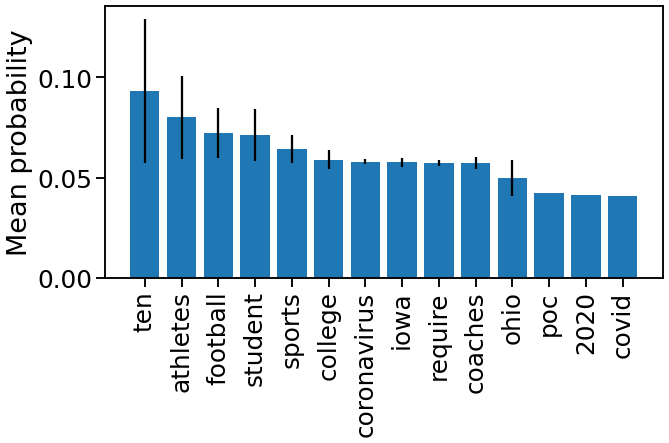

In [603]:
plt.figure(figsize=(10,5))
plt.bar(x_topics_means,y_means_sorted,yerr=y_std_sorted);
plt.ylabel('Mean probability')
# plt.xlabel('Topics')
sns.set_context('talk', font_scale=1.5)
plt.xticks(rotation=90);
# plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.pdf')
# plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.eps')
plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')

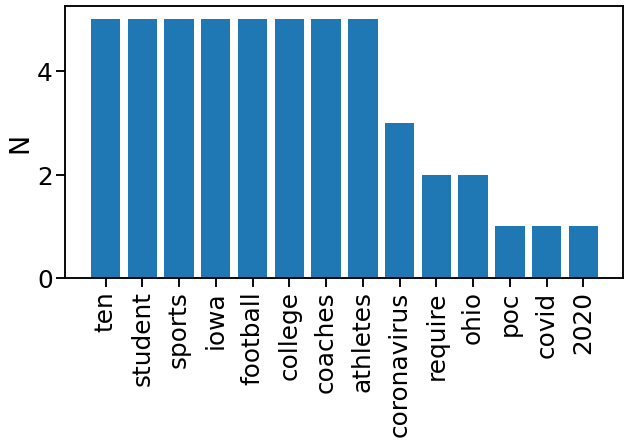

In [604]:
plt.figure(figsize=(10,5))
plt.bar(x_topics_freq,y_freq_sorted);
plt.ylabel('N')
# plt.xlabel('Topics')
sns.set_context('talk', font_scale=1.5)
plt.xticks(rotation=90);
# plt.savefig('./eda_figs/frequency_vs_topic_big_ten_resumes.pdf')
# plt.savefig('./eda_figs/frequency_vs_topic_big_ten_resumes.eps')
plt.savefig('./eda_figs/frequency_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')

In [538]:
os.getcwd()

'/Users/sagarsetru/Documents/post PhD positions search/insightDataScience/project/debiaser'

In [479]:
y_means

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [304]:
# Create a set of frequent meaningless words to remove
word_frequency_threshold = 2

# following https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py

# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stop_words]
         for document in [article_text]]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > word_frequency_threshold] for text in texts]

processed_dictionary = Dictionary(processed_corpus)
print(processed_dictionary)

Dictionary(6 unique tokens: ['coaches,', 'college', 'football', 'sports', 'student-athletes']...)


In [305]:
bow_corpus = [processed_dictionary.doc2bow(text) for text in processed_corpus]
lda_2 = gensim.models.LdaModel(corpus=bow_corpus,num_topics=5,id2word=processed_dictionary)

In [306]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_numeric

# # lda.top_topics(corpus=bow_corpus,dictionary=processed_dictionary)
# for i in range(0, lda.num_topics-1):
#     current_topic = lda.print_topic(i)
#     print(current_topic)
    
lda_topics = lda_2.show_topics()

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
#     print(topic)
    topics.append(preprocess_string(topic[1], filters))

all_topic_words = []
for topic in topics:
    print(topic)
    for topic_word in topic:
        print(topic_word)
        all_topic_words.append(topic_word)
    
    print(' ')

print(all_topic_words)

['ten', 'football', 'sports', 'student', 'athletes', 'coaches', 'college']
ten
football
sports
student
athletes
coaches
college
 
['ten', 'football', 'college', 'sports', 'coaches', 'student', 'athletes']
ten
football
college
sports
coaches
student
athletes
 
['ten', 'football', 'college', 'coaches', 'sports', 'student', 'athletes']
ten
football
college
coaches
sports
student
athletes
 
['ten', 'football', 'college', 'coaches', 'student', 'athletes', 'sports']
ten
football
college
coaches
student
athletes
sports
 
['ten', 'football', 'coaches', 'college', 'student', 'athletes', 'sports']
ten
football
coaches
college
student
athletes
sports
 
['ten', 'football', 'sports', 'student', 'athletes', 'coaches', 'college', 'ten', 'football', 'college', 'sports', 'coaches', 'student', 'athletes', 'ten', 'football', 'college', 'coaches', 'sports', 'student', 'athletes', 'ten', 'football', 'college', 'coaches', 'student', 'athletes', 'sports', 'ten', 'football', 'coaches', 'college', 'student', '

In [307]:
print(topics)

[['ten', 'football', 'sports', 'student', 'athletes', 'coaches', 'college'], ['ten', 'football', 'college', 'sports', 'coaches', 'student', 'athletes'], ['ten', 'football', 'college', 'coaches', 'sports', 'student', 'athletes'], ['ten', 'football', 'college', 'coaches', 'student', 'athletes', 'sports'], ['ten', 'football', 'coaches', 'college', 'student', 'athletes', 'sports']]


In [318]:
all_unique_topics = []
for topic_list in topics:
    for topic in topic_list:
        if topic not in all_unique_topics:
            all_unique_topics.append(topic)

print(all_unique_topics)

['ten', 'football', 'sports', 'student', 'athletes', 'coaches', 'college']


In [314]:
all_topics

['coaches', 'college', 'football', 'sports', 'student', 'ten', 'athletes']

In [312]:
len(topics[0])
print(topics[0])

['ten', 'football', 'sports', 'student', 'athletes', 'coaches', 'college']
